# DATA - 603: PROJECT

# Contents
## 1 Exploratory Data Analysis
* ### 1.1  <a href='#1.1'>Connecting to Spark and HDFS</a>
* ### 1.2  <a href='#1.2'> Examining the Metadata Files </a>
* ### 1.3  <a href='#1.3'>Reading the Image Label CSV's and merging them</a>
* ### 1.4  <a href='#1.4'>Examining the Label Names</a>
* ### 1.5  <a href='#1.5'>Examining the Bounding Boxes</a>
* ### 1.6  <a href='#1.6'>Showing a Sample Image</a>
* ### 1.7  <a href='#1.6'>Running ResNet50 on an Image</a>




## Connecting to Spark and HDFS <a id ="1.1"></a> 

In [1]:
import import_ipynb #importing import_ipynb notebook
from data603 import SparkLauncher # Running SparkLauncher notebook from "data603" folder
from data603 import HDFSLauncher # Getting HDFS connection with portnumber in HDFSLauncher notebook.

# Getting a Spark session
conf = SparkLauncher.get_spark_conf()
conf.set('spark.yarn.dist.files', 'keras_data/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
conf.set('spark.executor.memory', '60g')
spark = SparkLauncher.get_spark_session(conf, pack_venv = True)
hdfs = HDFSLauncher.get_hdfs()

importing Jupyter notebook from /scratch/data603_fall2020/akapoor2/data603/SparkLauncher.ipynb
importing Jupyter notebook from /scratch/data603_fall2020/akapoor2/data603/HDFSLauncher.ipynb
Packing Virtual Environment: /scratch/data603_admin/venv_cluster2 into akapoor2.tar.gz
Creating Spark Session: akapoor2_data603_spark_20201213_165746


## Examining the Metadata Files <a id ="1.2"></a>

In [2]:
hdfs.ls('/data/google_open_image')

['/data/google_open_image/bboxes',
 '/data/google_open_image/ids',
 '/data/google_open_image/images',
 '/data/google_open_image/labels',
 '/data/google_open_image/masks',
 '/data/google_open_image/metadata',
 '/data/google_open_image/relationships',
 '/data/google_open_image/segmentations']

In [3]:
# Looking into metadata
hdfs.ls('/data/google_open_image/metadata')

['/data/google_open_image/metadata/attributes-description.csv',
 '/data/google_open_image/metadata/class-descriptions-boxable.csv',
 '/data/google_open_image/metadata/classes-segmentation.txt',
 '/data/google_open_image/metadata/relationship-triplets.csv',
 '/data/google_open_image/metadata/relationships-description.csv']

In [4]:
# Exploring the parquet files present in etl folder
hdfs.ls('/etl/google_open_image')

['/etl/google_open_image/images',
 '/etl/google_open_image/images.parquet',
 '/etl/google_open_image/images_coalesced.parquet',
 '/etl/google_open_image/images_partitioned_sample.parquet',
 '/etl/google_open_image/images_updated.parquet']

In [5]:
# Image Label CSV's
hdfs.ls('/data/google_open_image/labels')

['/data/google_open_image/labels/test-annotations-human-imagelabels-boxable.csv',
 '/data/google_open_image/labels/train-annotations-human-imagelabels-boxable.csv',
 '/data/google_open_image/labels/validation-annotations-human-imagelabels-boxable.csv']

# Reading the Image Label CSV's and merging them <a id="1.3"></a>

In [6]:
# Reading the test, train and validation csv's into spark dataframes
test = spark.read.csv('/data/google_open_image/labels/test-annotations-human-imagelabels-boxable.csv', header = True)
train = spark.read.csv('/data/google_open_image/labels/train-annotations-human-imagelabels-boxable.csv', header = True)
validation = spark.read.csv('/data/google_open_image/labels/validation-annotations-human-imagelabels-boxable.csv', header = True)

In [7]:
# Individual rows count
print ("Test_count = {}\nTrain_count = {}\nValidation_count = {}".format (test.count() , train.count(), validation.count()))

Test_count = 772776
Train_count = 8996795
Validation_count = 256707


In [8]:
# Total rows count
print("agg_count = " , test.count()+train.count()+validation.count())

agg_count =  10026278


In [9]:
test.show(5)

+----------------+------------+---------+----------+
|         ImageID|      Source|LabelName|Confidence|
+----------------+------------+---------+----------+
|000026e7ee790996|verification| /m/0cgh4|         0|
|000026e7ee790996|verification|/m/04hgtk|         0|
|000026e7ee790996|verification| /m/0d5gx|         0|
|000026e7ee790996|verification| /m/07j7r|         1|
|000026e7ee790996|verification| /m/04rky|         0|
+----------------+------------+---------+----------+
only showing top 5 rows



In [10]:
train.show(5)

+----------------+------------+---------+----------+
|         ImageID|      Source|LabelName|Confidence|
+----------------+------------+---------+----------+
|000002b66c9c498e|verification|/m/014j1m|         0|
|000002b66c9c498e|verification|/m/014sv8|         1|
|000002b66c9c498e|verification| /m/01599|         0|
|000002b66c9c498e|verification| /m/015p6|         0|
|000002b66c9c498e|verification|/m/015x4r|         0|
+----------------+------------+---------+----------+
only showing top 5 rows



In [11]:
validation.show(5)

+----------------+------------+---------+----------+
|         ImageID|      Source|LabelName|Confidence|
+----------------+------------+---------+----------+
|0001eeaf4aed83f9|verification| /m/0cmf2|         1|
|0004886b7d043cfd|verification|/m/01g317|         0|
|0004886b7d043cfd|verification|/m/04hgtk|         0|
|0004886b7d043cfd|verification| /m/09j2d|         0|
|0004886b7d043cfd|verification|/m/0463sg|         0|
+----------------+------------+---------+----------+
only showing top 5 rows



In [12]:
from pyspark.sql.functions import lit
# Creating a new column named Subset to note where the data is from to keep the data specific even after union.
test1 = test.withColumn("Subset", lit("test"))
train1 = train.withColumn("Subset", lit("train"))
validation1 = validation.withColumn("Subset", lit("validation"))

In [13]:
validation1.show(5)

+----------------+------------+---------+----------+----------+
|         ImageID|      Source|LabelName|Confidence|    Subset|
+----------------+------------+---------+----------+----------+
|0001eeaf4aed83f9|verification| /m/0cmf2|         1|validation|
|0004886b7d043cfd|verification|/m/01g317|         0|validation|
|0004886b7d043cfd|verification|/m/04hgtk|         0|validation|
|0004886b7d043cfd|verification| /m/09j2d|         0|validation|
|0004886b7d043cfd|verification|/m/0463sg|         0|validation|
+----------------+------------+---------+----------+----------+
only showing top 5 rows



In [14]:
# Creating a new dataframe named images combining the three above dataframes
images = test1.union(train1).union(validation1)

In [15]:
images.count()

10026278

### agg_count is equal to image.count()

In [16]:
images.show(5)

+----------------+------------+---------+----------+------+
|         ImageID|      Source|LabelName|Confidence|Subset|
+----------------+------------+---------+----------+------+
|000026e7ee790996|verification| /m/0cgh4|         0|  test|
|000026e7ee790996|verification|/m/04hgtk|         0|  test|
|000026e7ee790996|verification| /m/0d5gx|         0|  test|
|000026e7ee790996|verification| /m/07j7r|         1|  test|
|000026e7ee790996|verification| /m/04rky|         0|  test|
+----------------+------------+---------+----------+------+
only showing top 5 rows



In [17]:
# checking for any NaN or NULL value in the dataframe
from pyspark.sql.functions import isnan, when, count, col
images.select([count(when(isnan(c), c)).alias(c) for c in images.columns]).toPandas().T

,0
ImageID,0
Source,0
LabelName,0
Confidence,0
Subset,0


In [18]:
images.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           images.columns]).toPandas().T

,0
ImageID,0
Source,0
LabelName,0
Confidence,0
Subset,0


### No Null or NaN column 

# Examining the Label Names <a id ="1.4"></a> 

In [19]:

#label_schema = StructType([
#    StructField("ImageID", StringType()),
#    StructField("Source", StringType()),
#    StructField("LabelName", StringType()),
#    StructField("Confidence", DoubleType())
#])

#labels_validation = spark.read\
#                         .csv('/data/google_open_image/labels/validation-annotations-human-imagelabels-boxable.csv', 
#                              header = True,
#                              schema = label_schema)

In [20]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, StringType, IntegerType
labels = spark.read.csv('/data/google_open_image/metadata/class-descriptions-boxable.csv', 
                        schema = StructType([StructField("LabelName", StringType()), 
                                             StructField("LabelText", StringType())]) )

In [21]:
labels.show(10)

+-----------+----------+
|  LabelName| LabelText|
+-----------+----------+
|  /m/011k07|  Tortoise|
|/m/011q46kg| Container|
|  /m/012074|    Magpie|
|  /m/0120dh|Sea turtle|
|  /m/01226z|  Football|
|  /m/012n7d| Ambulance|
|  /m/012w5l|    Ladder|
|  /m/012xff|Toothbrush|
|  /m/012ysf|   Syringe|
|  /m/0130jx|      Sink|
+-----------+----------+
only showing top 10 rows



In [22]:
# Count of unique LabelNames
labels.count()

601

In [23]:
# Joining labels and image dataframe on LabelName column
images_labels = images.join(labels, on = 'LabelName', how = 'left')

In [24]:
images_labels.count()

10026278

In [25]:
images_labels.show(5)

+---------+----------------+------------+----------+------+----------+
|LabelName|         ImageID|      Source|Confidence|Subset| LabelText|
+---------+----------------+------------+----------+------+----------+
| /m/0cgh4|000026e7ee790996|verification|         0|  test|  Building|
|/m/04hgtk|000026e7ee790996|verification|         0|  test|Human head|
| /m/0d5gx|000026e7ee790996|verification|         0|  test|    Castle|
| /m/07j7r|000026e7ee790996|verification|         1|  test|      Tree|
| /m/04rky|000026e7ee790996|verification|         0|  test|    Mammal|
+---------+----------------+------------+----------+------+----------+
only showing top 5 rows



In [26]:
label_count = images_labels.groupby('LabelText').count()

In [27]:
# Grouping all the LabelText strings and displaying their count
images_labels.groupby('LabelText').count().show()

+-------------+------+
|    LabelText| count|
+-------------+------+
|       Flower|143348|
|        Drink| 43263|
|     Goldfish|   982|
|        Sword|   801|
|    Golf cart|   729|
|         Oboe|   486|
|       Muffin|  2354|
|       Turtle|  2168|
|         Swan|  2129|
|         Tire| 62454|
|       Ladder|  1803|
|        Goose|  4013|
|      Dolphin|  1762|
|      Spatula|   318|
|       Shrimp|  1627|
|        Tiara|   861|
|      Missile|   954|
|Bow and arrow|   824|
|    Human leg| 42008|
|        Clock| 14975|
+-------------+------+
only showing top 20 rows



In [28]:
# Converting spark dataframe to pandas dataframe
from pyspark.sql.functions import desc

In [29]:
#Decending order of LabelText on the basis of their count
label_count.sort("count").show(truncate=False)

+--------------------+-----+
|LabelText           |count|
+--------------------+-----+
|Paper cutter        |95   |
|Grinder             |101  |
|Hair spray          |146  |
|Ratchet (Device)    |176  |
|Cooking spray       |180  |
|Can opener          |183  |
|Chisel              |184  |
|Band-aid            |188  |
|Pencil sharpener    |200  |
|Stapler             |202  |
|Cocktail shaker     |213  |
|Facial tissue holder|213  |
|Hair dryer          |220  |
|Chime               |224  |
|Bottle opener       |226  |
|Harmonica           |230  |
|Bomb                |231  |
|Maracas             |236  |
|Eraser              |239  |
|Torch               |239  |
+--------------------+-----+
only showing top 20 rows



In [30]:
#Decending order of LabelText on the basis of their count
label_count.orderBy('count', ascending=False).show()

+------------+------+
|   LabelText| count|
+------------+------+
|      Person|892037|
|    Clothing|720911|
|         Man|492675|
|       Plant|486300|
|        Tree|458747|
|  Human face|410061|
|       Woman|393642|
|        Girl|299439|
|     Vehicle|283084|
|    Building|272843|
|    Footwear|236402|
|Land vehicle|197046|
|         Car|169802|
|      Animal|156350|
|       Wheel|144995|
|      Flower|143348|
|         Boy|125954|
|        Food|121823|
|       House|110116|
|      Mammal|107119|
+------------+------+
only showing top 20 rows



In [31]:
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
images_labels.groupby('LabelText').count()

DataFrame[LabelText: string, count: bigint]

In [33]:
df = label_count.toPandas()

In [34]:
label_count1 = label_count.orderBy('count', ascending=False)

In [35]:
df1 = label_count1.limit(10).toPandas()

Text(0, 0.5, 'Count')

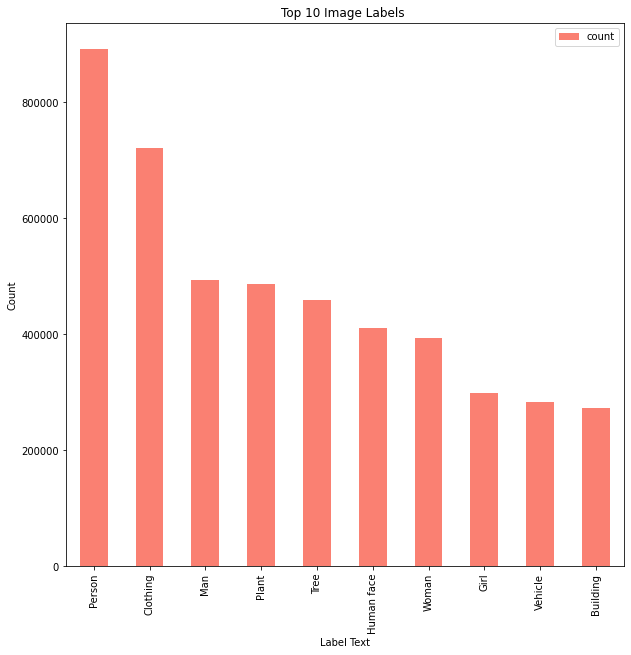

In [36]:
# Plotting the decending order of LabelText on the basis of count
ax = df1.plot(kind='bar', x='LabelText', y='count',color='salmon', title = "Top 10 Image Labels ", figsize=(10,10))

ax.set_xlabel("Label Text")
ax.set_ylabel("Count")

In [37]:
#label_count.orderBy('count', ascending=True).show()
df2 = label_count.orderBy('count', ascending=True).limit(10).toPandas()

Text(0, 0.5, 'Count')

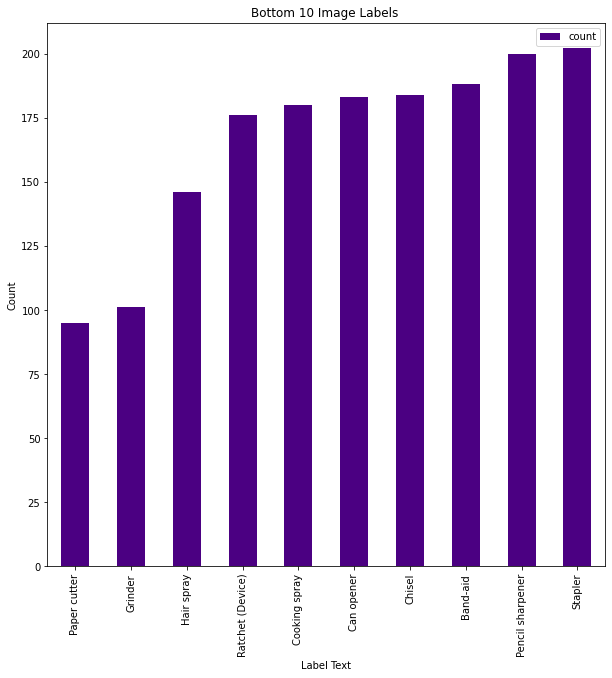

In [113]:
#Plotting the last 10 LabelNames based on their count
ax = df2.plot(kind='bar', x='LabelText', y='count',color='indigo', title = "Bottom 10 Image Labels ", figsize=(10,10))

ax.set_xlabel("Label Text")
ax.set_ylabel("Count")

In [39]:
!pip install wordcloud

  Using cached wordcloud-1.8.1-cp36-cp36m-manylinux1_x86_64.whl (366 kB)
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/scratch/data603_admin/venv/lib64/python3.6/site-packages/wordcloud-1.8.1.dist-info'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the '/scratch/data603_admin/venv/bin/python3 -m pip install --upgrade pip' command.


In [40]:
#import WordCloud
#import matplotlib.pyplot as plt

In [41]:
#text = df1['Label Text'].values 

#wordcloud = WordCloud().generate(str(text))

#plt.imshow(wordcloud)
#plt.axis("off")
#plt.show()

### Form the above we can conclude that over all the images, person is the most appeared Label and Paper Cutter will be the least observed label.

# Examining the Bounding Box <a id="1.5"></a>

In [42]:
hdfs.ls('/data/google_open_image/bboxes')

['/data/google_open_image/bboxes/test-annotations-bbox.csv',
 '/data/google_open_image/bboxes/train-annotations-bbox.csv',
 '/data/google_open_image/bboxes/validation-annotations-bbox.csv']

In [43]:
#Reading the CSV in hdfs into spark dataframe object
bb_test = spark.read.csv('/data/google_open_image/bboxes/test-annotations-bbox.csv',header = True) 
bb_train = spark.read.csv('/data/google_open_image/bboxes/train-annotations-bbox.csv',header = True) 
bb_validation = spark.read.csv('/data/google_open_image/bboxes/validation-annotations-bbox.csv',header = True) 

In [44]:
bb_test.show(5)

+----------------+------+---------+----------+----------+----------+----------+----------+----------+-----------+---------+-----------+--------+
|         ImageID|Source|LabelName|Confidence|      XMin|      XMax|      YMin|      YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|
+----------------+------+---------+----------+----------+----------+----------+----------+----------+-----------+---------+-----------+--------+
|000026e7ee790996|xclick| /m/07j7r|         1|  0.071875| 0.1453125|   0.20625|0.39166668|         0|          1|        1|          0|       0|
|000026e7ee790996|xclick| /m/07j7r|         1| 0.4390625|  0.571875|0.26458332|0.43541667|         0|          1|        1|          0|       0|
|000026e7ee790996|xclick| /m/07j7r|         1|   0.66875|         1|         0| 0.5520833|         0|          1|        1|          0|       0|
|000062a39995e348|xclick| /m/015p6|         1|0.20620842|  0.849224|0.15463917|         1|         0|          0|        0|       

In [45]:
bb_train.show(5)

+----------------+------+---------+----------+--------+--------+--------+--------+----------+-----------+---------+-----------+--------+
|         ImageID|Source|LabelName|Confidence|    XMin|    XMax|    YMin|    YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|
+----------------+------+---------+----------+--------+--------+--------+--------+----------+-----------+---------+-----------+--------+
|000002b66c9c498e|xclick|/m/01g317|         1|0.012500|0.195312|0.148438|0.587500|         0|          1|        0|          0|       0|
|000002b66c9c498e|xclick|/m/01g317|         1|0.025000|0.276563|0.714063|0.948438|         0|          1|        0|          0|       0|
|000002b66c9c498e|xclick|/m/01g317|         1|0.151562|0.310937|0.198437|0.590625|         1|          0|        0|          0|       0|
|000002b66c9c498e|xclick|/m/01g317|         1|0.256250|0.429688|0.651563|0.925000|         1|          0|        0|          0|       0|
|000002b66c9c498e|xclick|/m/01g317|      

In [46]:
bb_validation.show(5)

+----------------+------+---------+----------+-----------+----------+----------+----------+----------+-----------+---------+-----------+--------+
|         ImageID|Source|LabelName|Confidence|       XMin|      XMax|      YMin|      YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|
+----------------+------+---------+----------+-----------+----------+----------+----------+----------+-----------+---------+-----------+--------+
|0001eeaf4aed83f9|xclick| /m/0cmf2|         1|0.022673031| 0.9642005|0.07103825|0.80054647|         0|          0|        0|          0|       0|
|000595fe6fee6369|xclick| /m/02wbm|         1|          0|         1|         0|         1|         0|          0|        1|          0|       0|
|000595fe6fee6369|xclick| /m/02xwb|         1|  0.1413844|  0.179676|0.67627496|0.73170733|         0|          0|        0|          0|       0|
|000595fe6fee6369|xclick| /m/02xwb|         1| 0.21354933| 0.2533137|0.29933482|0.35476717|         1|          0|        0|

In [47]:
print ("bb_Test_count = {}\nbb_Train_count = {}\nbb_Validation_count = {}".format (bb_test.count() , bb_train.count(), bb_validation.count()))

bb_Test_count = 937327
bb_Train_count = 14610229
bb_Validation_count = 303980


In [48]:
print("bb_agg_count = ",(bb_test.count() + bb_train.count() + bb_validation.count()))

bb_agg_count =  15851536


In [49]:
bb_test = bb_test.withColumn("Subset", lit("test"))
bb_train = bb_train.withColumn("Subset", lit("train"))
bb_validation = bb_validation.withColumn("Subset", lit("validation"))

In [50]:
bb = bb_test.union(bb_train).union(bb_validation)

In [51]:
bb.show(5)

+----------------+------+---------+----------+----------+----------+----------+----------+----------+-----------+---------+-----------+--------+------+
|         ImageID|Source|LabelName|Confidence|      XMin|      XMax|      YMin|      YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|Subset|
+----------------+------+---------+----------+----------+----------+----------+----------+----------+-----------+---------+-----------+--------+------+
|000026e7ee790996|xclick| /m/07j7r|         1|  0.071875| 0.1453125|   0.20625|0.39166668|         0|          1|        1|          0|       0|  test|
|000026e7ee790996|xclick| /m/07j7r|         1| 0.4390625|  0.571875|0.26458332|0.43541667|         0|          1|        1|          0|       0|  test|
|000026e7ee790996|xclick| /m/07j7r|         1|   0.66875|         1|         0| 0.5520833|         0|          1|        1|          0|       0|  test|
|000062a39995e348|xclick| /m/015p6|         1|0.20620842|  0.849224|0.15463917|         

In [52]:
# checking for any NaN or NULL value in the dataframe
bb.select([count(when(isnan(c), c)).alias(c) for c in bb.columns]).toPandas().T

,0
ImageID,0
Source,0
LabelName,0
Confidence,0
XMin,0
XMax,0
YMin,0
YMax,0
IsOccluded,0
IsTruncated,0


In [53]:
bb.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           bb.columns]).toPandas().T

,0
ImageID,0
Source,0
LabelName,0
Confidence,0
XMin,0
XMax,0
YMin,0
YMax,0
IsOccluded,0
IsTruncated,0


#### No NULL or Nan Values

# Showing a Sample Image  <a id="1.6"></a>

In [54]:
fork = images_labels.where('LabelText = "Fork"')

In [55]:
fork.count()

1821

In [56]:
fork = images_labels.where('LabelText = "Fork"')
spoon = images_labels.where('LabelText = "Spoon"')
pizza = images_labels.where('LabelText = "Pizza Cutter"')
cup = images_labels.where('LabelText = "Measuring Cup"')
bottle = images_labels.where('LabelText = "Bottle Opener"')
knife = images_labels.where('LabelText = "Knife"')
straw = images_labels.where('LabelText = "Drinking Straw"')
whisk = images_labels.where('LabelText = "Whisk"')
board = images_labels.where('LabelText = "Cutting Board"')
spatula = images_labels.where('LabelText = "Spatula"')
scale = images_labels.where('LabelText = "Scale"')
chopsticks = images_labels.where('LabelText = "Chopsticks"')

In [57]:
fork.count()+spoon.count()+pizza.count()+cup.count()+bottle.count()+knife.count()+straw.count()+whisk.count()+board.count()+spatula.count()+scale.count()+chopsticks.count()

7955

In [58]:
fork.count()+spoon.count()+knife.count()

5582

In [59]:
kitchen = fork.union(spoon).union(knife)

In [60]:
kitchen.show(5)

+---------+----------------+------------+----------+------+---------+
|LabelName|         ImageID|      Source|Confidence|Subset|LabelText|
+---------+----------------+------------+----------+------+---------+
| /m/0dt3t|01e8801080744de2|verification|         1|  test|     Fork|
| /m/0dt3t|025d691725d76090|verification|         0|  test|     Fork|
| /m/0dt3t|03b12e58a798c108|verification|         1|  test|     Fork|
| /m/0dt3t|03f4adcebcf3f439|verification|         1|  test|     Fork|
| /m/0dt3t|049ea73ac853d016|verification|         1|  test|     Fork|
+---------+----------------+------------+----------+------+---------+
only showing top 5 rows



In [61]:
fork.show(5)

+---------+----------------+------------+----------+------+---------+
|LabelName|         ImageID|      Source|Confidence|Subset|LabelText|
+---------+----------------+------------+----------+------+---------+
| /m/0dt3t|01e8801080744de2|verification|         1|  test|     Fork|
| /m/0dt3t|025d691725d76090|verification|         0|  test|     Fork|
| /m/0dt3t|03b12e58a798c108|verification|         1|  test|     Fork|
| /m/0dt3t|03f4adcebcf3f439|verification|         1|  test|     Fork|
| /m/0dt3t|049ea73ac853d016|verification|         1|  test|     Fork|
+---------+----------------+------------+----------+------+---------+
only showing top 5 rows



In [62]:
import pyspark.sql.functions as F
fork = fork.select("ImageID")

In [63]:
fork.show(3)

+----------------+
|         ImageID|
+----------------+
|01e8801080744de2|
|025d691725d76090|
|03b12e58a798c108|
+----------------+
only showing top 3 rows



In [64]:
fork.write.parquet(path = "/user/akapoor2/final_test.parquet", mode ="overwrite")

In [65]:
image_data = spark.read.parquet("/etl/google_open_image/images_updated.parquet")

In [66]:
image_data.show(1)

+----------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+------------+--------------------+--------------------+--------+------+
|         ImageID|Format|                Data|         OriginalURL|  OriginalLandingURL|             License|    AuthorProfileURL|          Author|               Title|OriginalSize|         OriginalMD5|    Thumbnail300KURL|Rotation|Subset|
+----------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+------------+--------------------+--------------------+--------+------+
|8b64977dbb0b8817|   JPG|[FF D8 FF E0 00 1...|https://farm8.sta...|https://www.flick...|https://creativec...|https://www.flick...|James Gochenouer|Nara Mitarai and ...|      463413|NSRx8p8BtzalhO86y...|https://c6.static...|     0.0| train|
+----------------+------+---------------

In [67]:
image_data

DataFrame[ImageID: string, Format: string, Data: binary, OriginalURL: string, OriginalLandingURL: string, License: string, AuthorProfileURL: string, Author: string, Title: string, OriginalSize: string, OriginalMD5: string, Thumbnail300KURL: string, Rotation: string, Subset: string]

In [68]:
image_data = image_data.select(['ImageID', 'Data'])

In [69]:
image_data.show(2)

+----------------+--------------------+
|         ImageID|                Data|
+----------------+--------------------+
|8b64977dbb0b8817|[FF D8 FF E0 00 1...|
|0000d59fa570d973|[FF D8 FF E0 00 1...|
+----------------+--------------------+
only showing top 2 rows



In [70]:
fork = spark.read.parquet("/user/akapoor2/final_test.parquet")

In [71]:
fork1 = fork.join(image_data, on="ImageID")

In [72]:
fork1.show(1)

+----------------+--------------------+
|         ImageID|                Data|
+----------------+--------------------+
|005f9567f94efa14|[FF D8 FF E0 00 1...|
+----------------+--------------------+
only showing top 1 row



In [73]:
bounding_boxes = spark.read.csv('/data/google_open_image/bboxes/*.csv',
                                header=True)

In [74]:
fork_boxes = fork1.join(bounding_boxes,
                              on = "ImageID")

In [75]:
fork = fork_boxes.sample(0.2).limit(2)

In [76]:
def extract_sub_image(data, xmin, xmax, ymin, ymax):
    import io
    from PIL import Image

    img = Image.open(io.BytesIO(data))
    (width, height) = img.size
    xmin = int(float(xmin) * width)
    xmax = int(float(xmax) * width)
    ymin = int(float(ymin) * height)
    ymax = int(float(ymax) * height)

    chip = img.crop(box = (xmin,ymin,xmax,ymax))
    buf = io.BytesIO()
    chip.save(buf, format = 'JPEG')
    
    return buf.getvalue()

In [77]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

udf_extract_sub = F.udf(extract_sub_image, T.BinaryType())

In [78]:
fork = fork.withColumn("ChipData", udf_extract_sub("Data", "XMin", "XMax", "YMin", "YMax"))

In [79]:
fork.show(1)

+----------------+--------------------+------+---------+----------+--------+--------+--------+--------+----------+-----------+---------+-----------+--------+--------------------+
|         ImageID|                Data|Source|LabelName|Confidence|    XMin|    XMax|    YMin|    YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|            ChipData|
+----------------+--------------------+------+---------+----------+--------+--------+--------+--------+----------+-----------+---------+-----------+--------+--------------------+
|042a007257fd7ab5|[FF D8 FF E0 00 1...|xclick|/m/08dz3q|         1|0.606771|0.998698|0.153320|0.269531|         0|          1|        0|          0|       0|[FF D8 FF E0 00 1...|
+----------------+--------------------+------+---------+----------+--------+--------+--------+--------+----------+-----------+---------+-----------+--------+--------------------+
only showing top 1 row



In [80]:
for_avro = fork.select(["ImageID","LabelName","ChipData"])

In [81]:
for_avro.write.format("com.databricks.spark.avro").save("/user/akapoor2/final_test15.avro")

In [82]:
local_df = for_avro.toPandas()

In [83]:
local_df

,ImageID,LabelName,ChipData
0,025d691725d76090,/m/027rl48,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,..."
1,849c6044e6be36ba,/m/0dt3t,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,..."


In [84]:
from PIL import Image
import io
def show_image(img_data):
    return Image.open(io.BytesIO(img_data))

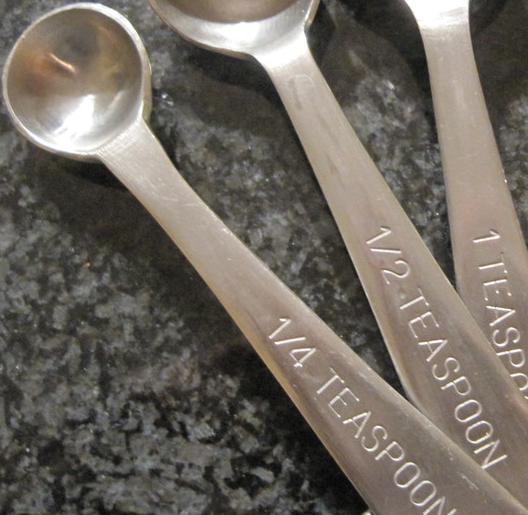

In [85]:
show_image(local_df.ChipData[0])

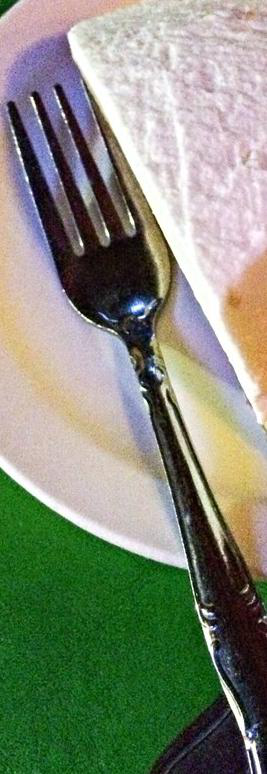

In [86]:
show_image(local_df.ChipData[1])

# Running ResNet50 on an Image  <a id="1.7"></a>

In [87]:
from keras.applications.resnet50 import ResNet50

# 100% size: 224x224 image
model = ResNet50(weights = './keras_data/resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                 include_top = True,)

In [88]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [89]:
fork.show(1)

+----------------+--------------------+---------+---------+----------+--------+--------+--------+--------+----------+-----------+---------+-----------+--------+--------------------+
|         ImageID|                Data|   Source|LabelName|Confidence|    XMin|    XMax|    YMin|    YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|            ChipData|
+----------------+--------------------+---------+---------+----------+--------+--------+--------+--------+----------+-----------+---------+-----------+--------+--------------------+
|00091ff4ef20390c|[FF D8 FF E0 00 1...|activemil| /m/02wbm|         1|0.448125|0.641250|0.555833|0.772500|        -1|         -1|       -1|         -1|      -1|[FF D8 FF E0 00 1...|
+----------------+--------------------+---------+---------+----------+--------+--------+--------+--------+----------+-----------+---------+-----------+--------+--------------------+
only showing top 1 row



In [90]:
for_chips = fork.select(["ImageID","LabelName","ChipData"])

In [91]:
for_chips.write.parquet(path = "/user/akapoor2/chips.parquet", mode ="overwrite")

In [92]:
image_chips = spark.read.parquet("/user/akapoor2/chips.parquet")

In [93]:
image_chips.count()

2

In [94]:
image_chips.show()

+----------------+----------+--------------------+
|         ImageID| LabelName|            ChipData|
+----------------+----------+--------------------+
|025d691725d76090|/m/027rl48|[FF D8 FF E0 00 1...|
|849c6044e6be36ba|  /m/0dt3t|[FF D8 FF E0 00 1...|
+----------------+----------+--------------------+



In [105]:
image_chips.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- ChipData: binary (nullable = true)
 |-- n: long (nullable = false)
 |-- grp: integer (nullable = true)
 |-- prediction_label: string (nullable = false)
 |-- prediction_confidence: double (nullable = false)



In [100]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import IntegerType

def group_id(n):
    ret = n % 10
    return ret

udf_group_id = udf(group_id, IntegerType())

# create the counter 1 - # of rows
image_chips = image_chips.withColumn("n", monotonically_increasing_id())

# modulo the counter to get a repeating pattern of 0,1,2,3,4,5,6,7,8,9 for the group number
image_chips = image_chips.withColumn("grp", udf_group_id("n"))

In [101]:
# create two empty columns for result of udf
image_chips = image_chips.withColumn('prediction_label', lit(""))
image_chips = image_chips.withColumn('prediction_confidence', lit(0.0))

In [108]:
import pandas as pd

from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(image_chips.schema, PandasUDFType.GROUPED_MAP)
def evaluate_chip(pdf):
    # pdf is a pandas dataframe
    import io
    import os
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input
    from keras.applications.resnet50 import decode_predictions
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array

    # Load Model Data
    model = ResNet50(weights = f'{os.getcwd()}/resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                 include_top = True)

    # Create arrays to hold prediction outputs.
    prediction_label = []
    prediction_confidence = []
    for chip_data in pdf['ChipData']:

        # Load the image
        img = load_img(io.BytesIO(chip_data), target_size = (224,224))

        # Prepare Image
        image = img_to_array(img)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)

        # Run prediction
        yhat = model.predict(image)

        # Decode Predictions
        label = decode_predictions(yhat)
        label = label[0][0]  # Get first prediction (most confident)
        
        # Save prediction results in arrays
        prediction_label.append(label[1])
        prediction_confidence.append(label[2])

    # Assign result array data to the correct columns in the pandas dataframe
    pdf['prediction_label'] = prediction_label
    pdf['prediction_confidence'] = prediction_confidence
    
    return pdf

In [111]:
image_chips = image_chips.groupby('grp').apply(evaluate_chip)

In [112]:
image_chips.select(['prediction_label', 'prediction_confidence']).show(1)

Py4JJavaError: An error occurred while calling o1134.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: 
Aborting TaskSet 193.0 because task 191 (partition 191)
cannot run anywhere due to node and executor blacklist.
Most recent failure:
Lost task 191.1 in stage 193.0 (TID 29071, worker1.hdp-internal, executor 16): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 283, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 108, in wrapped
    result = f(pd.concat(value_series, axis=1))
  File "/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-97-4e979da62ec3>", line 26, in evaluate_chip
  File "/data/hadoop/drive-k/yarn/nm/usercache/akapoor2/appcache/application_1601480466862_0452/container_1601480466862_0452_01_000021/akapoor2/lib64/python3.6/site-packages/tensorflow/python/keras/preprocessing/image.py", line 301, in load_img
    target_size=target_size, interpolation=interpolation)
  File "/data/hadoop/drive-k/yarn/nm/usercache/akapoor2/appcache/application_1601480466862_0452/container_1601480466862_0452_01_000021/akapoor2/lib64/python3.6/site-packages/keras_preprocessing/image/utils.py", line 113, in load_img
    with open(path, 'rb') as f:
TypeError: expected str, bytes or os.PathLike object, not _io.BytesIO

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:624)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1124)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:224)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.writeIteratorToStream(PythonUDFRunner.scala:50)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:345)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1948)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:194)


Blacklisting behavior can be configured via spark.blacklist.*.

	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1890)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2111)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2049)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:740)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2081)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2102)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2121)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3383)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2758)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.GeneratedMethodAccessor79.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [114]:
image_chips.schema

StructType(List(StructField(ImageID,StringType,true),StructField(LabelName,StringType,true),StructField(ChipData,BinaryType,true),StructField(n,LongType,false),StructField(grp,IntegerType,true),StructField(prediction_label,StringType,false),StructField(prediction_confidence,DoubleType,false)))

In [115]:
spark.stop()